<h1>Dataloading</h1>

In [1]:
import os
from glob import glob
import shutil
from tqdm import tqdm
import dicom2nifti
import numpy as np
import nibabel as nib
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism


def prepare(in_dir, imaging_index, pixdim=(1.0, 1.0, 1.0), a_min=0, a_max=503, spatial_size=[128,128,128], trainloader_batchsize=1):
    print("Preparing...")
    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, f"images_{imaging_index}", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "segmentation", "*.nii.gz")))

    '''DEBUG'''
    print(f"Length of path_train_volumes: {len(path_train_volumes)}")    
    print(f"Length of path_train_segmentation: {len(path_train_segmentation)}")    
    '''DEBUG'''

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
    train_loader = DataLoader(train_ds, batch_size=trainloader_batchsize)
    print("Preparing done.")

    return train_loader



In [2]:
training_directory="D:/MLDatasets/TCGA-GBM Datasets/Training"

'''CHANGE IMAGING INDEX FOR TYPE OF MRI'''
imaging_index=0 # Use FLAIR as main
data_f = prepare(in_dir=training_directory, imaging_index=imaging_index)

trainloader = data_f

Preparing...
Length of path_train_volumes: 102
Length of path_train_segmentation: 102


Loading dataset: 100%|██████████| 102/102 [01:18<00:00,  1.30it/s]

Preparing done.


<h1>Data Imaging</h1>

Image shape is: torch.Size([1, 1, 128, 128, 128])
Label shape is: torch.Size([1, 1, 128, 128, 128])


C:\Users\steve\AppData\Local\Temp\ipykernel_1668\3135923410.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(50, 100)):


  0%|          | 0/50 [00:00<?, ?it/s]

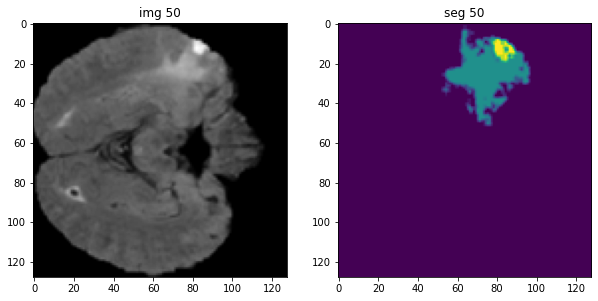

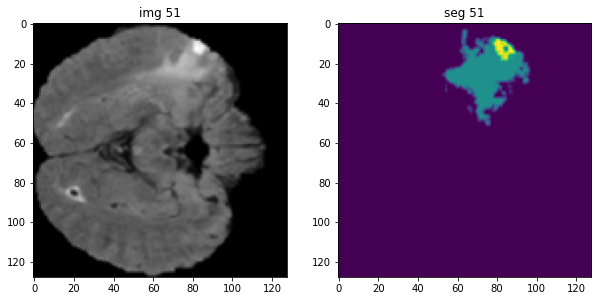

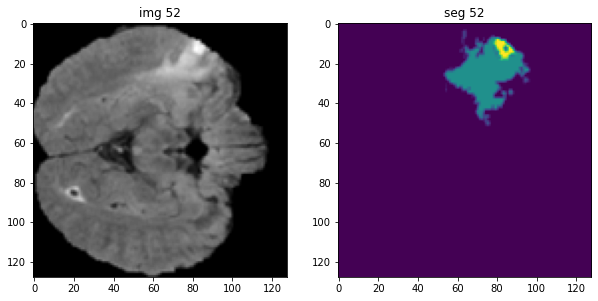

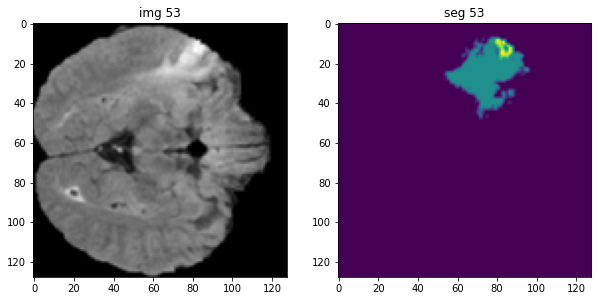

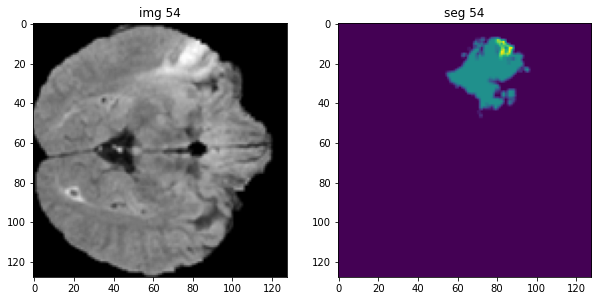

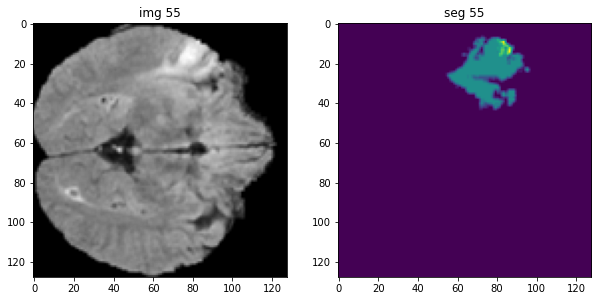

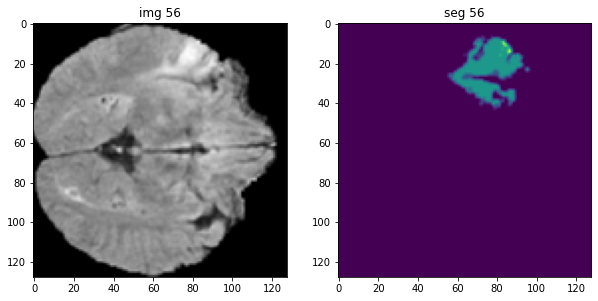

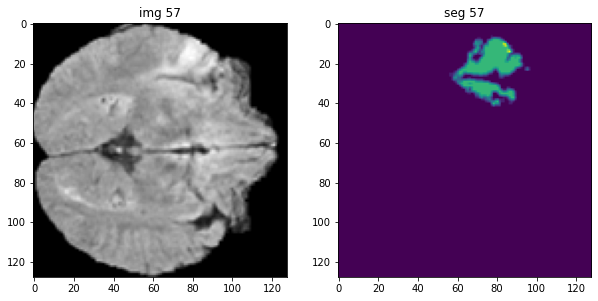

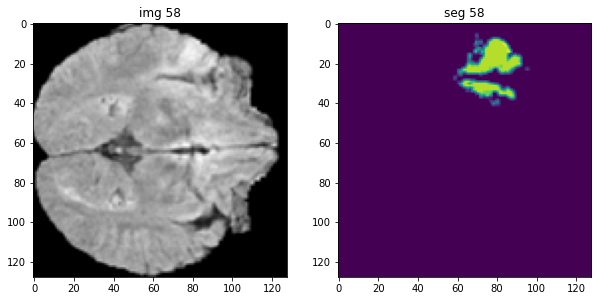

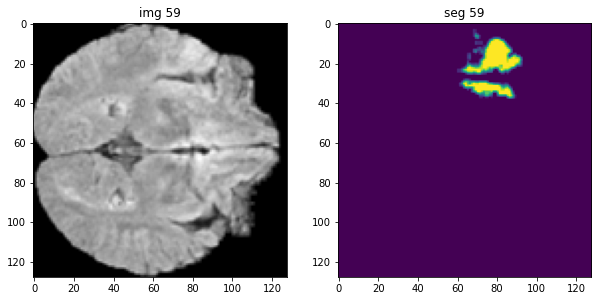

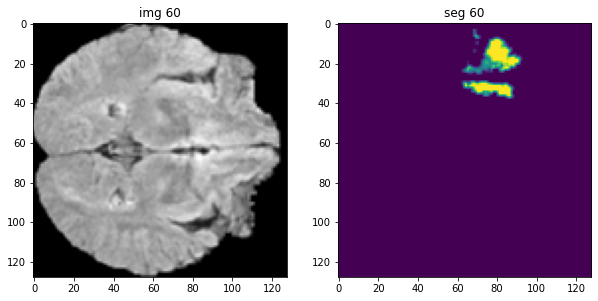

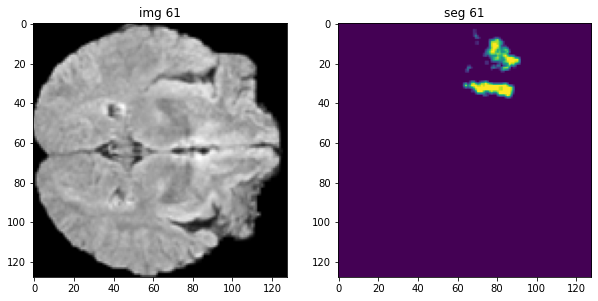

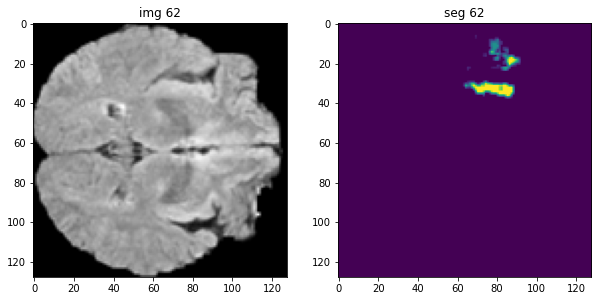

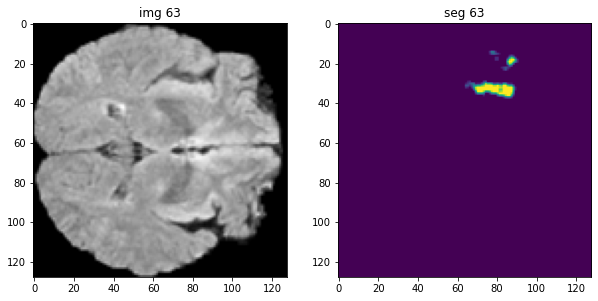

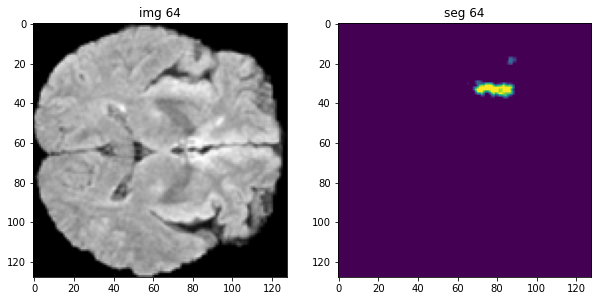

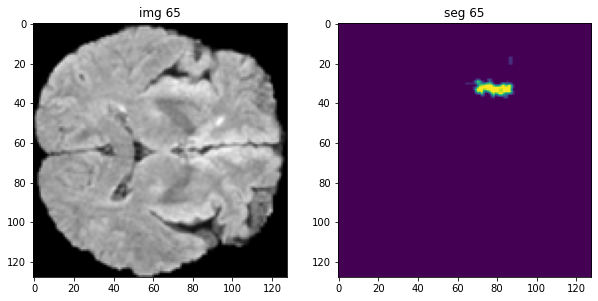

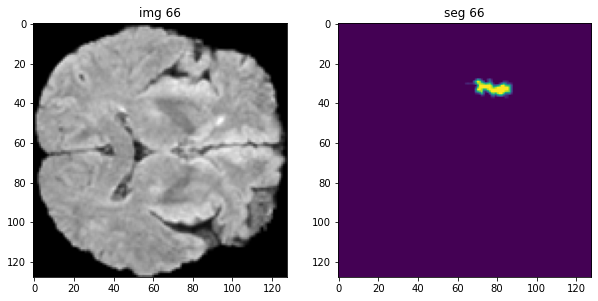

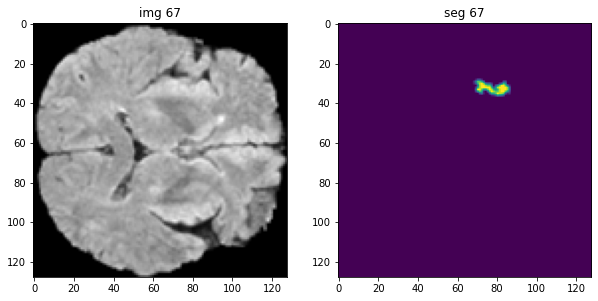

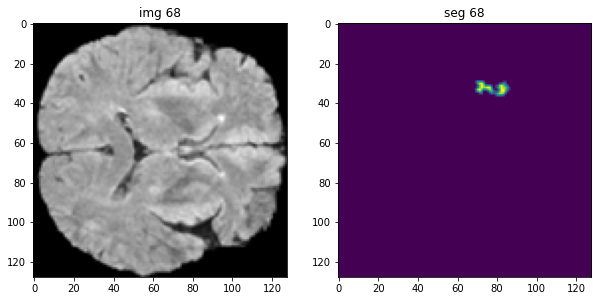

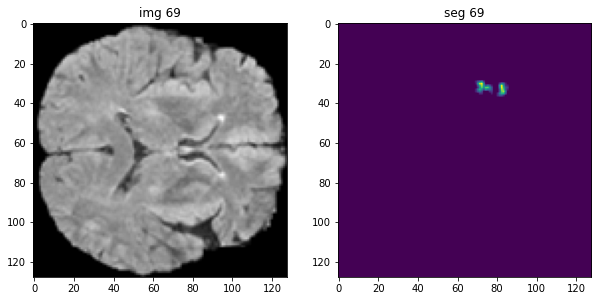

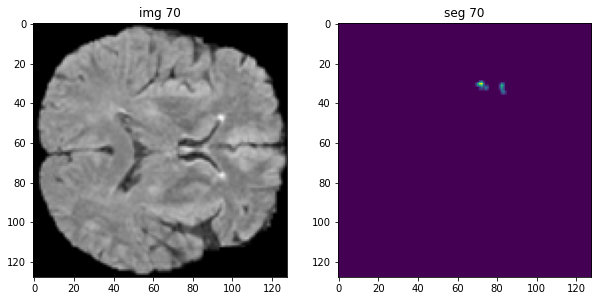

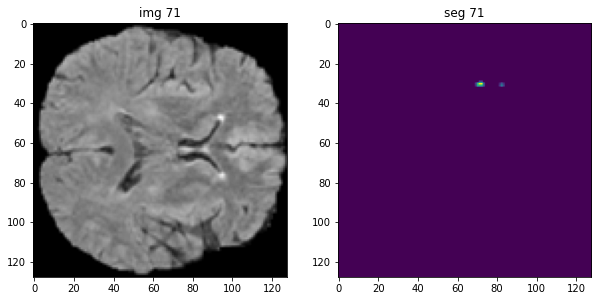

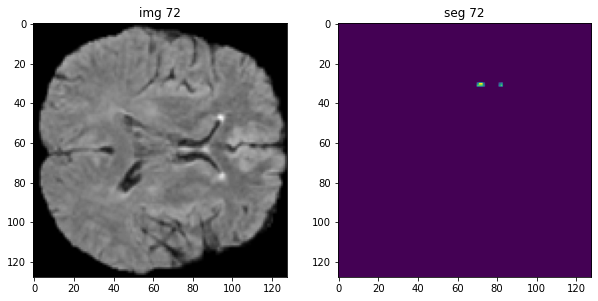

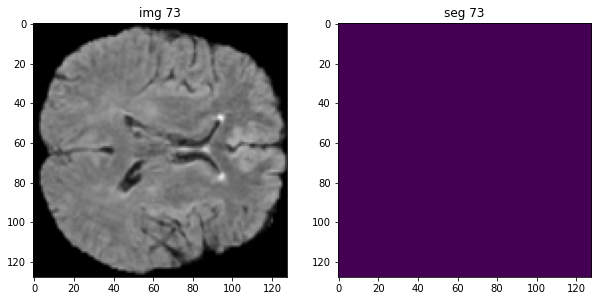

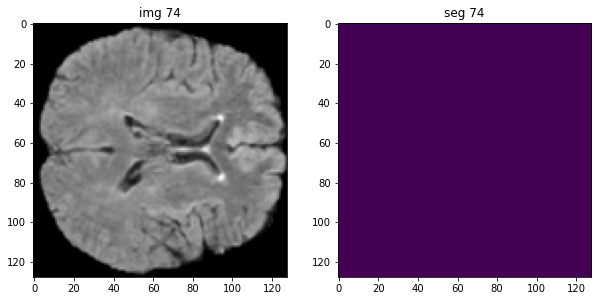

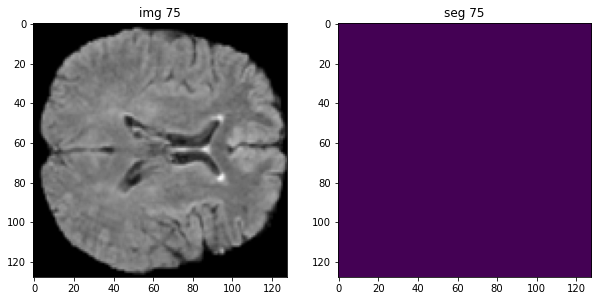

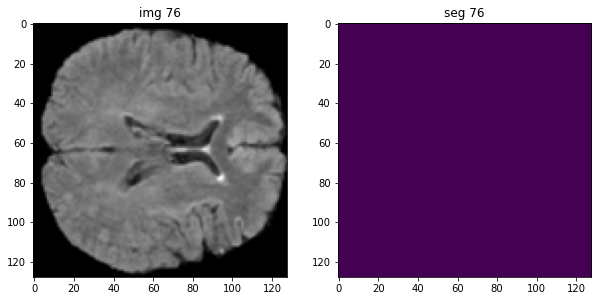

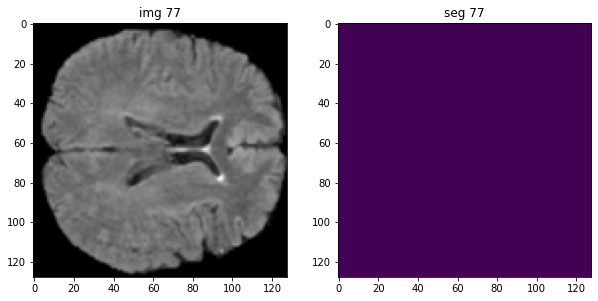

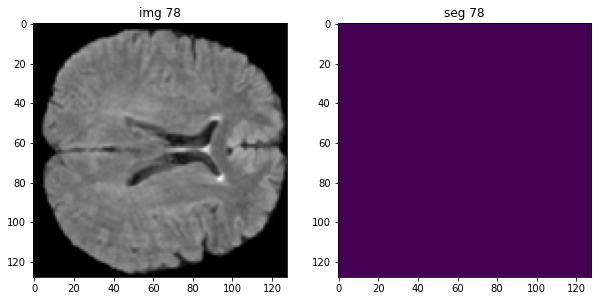

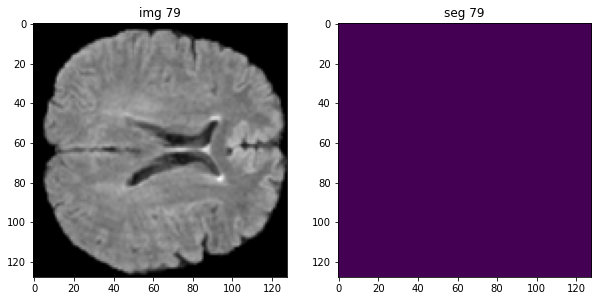

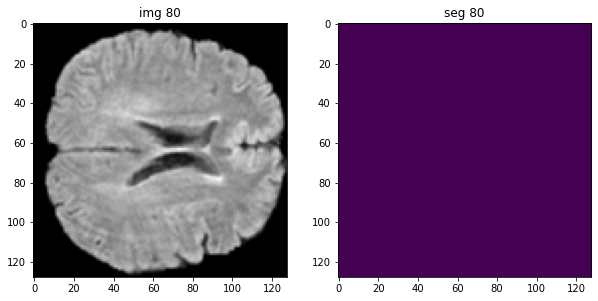

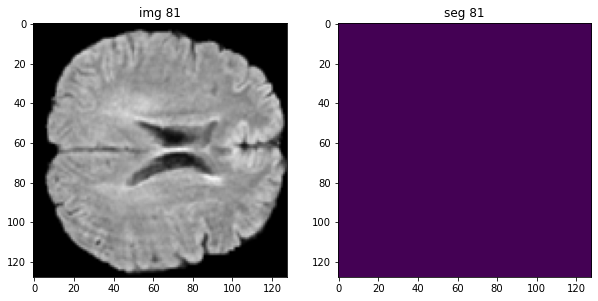

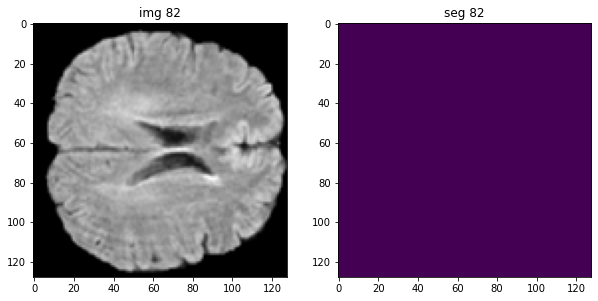

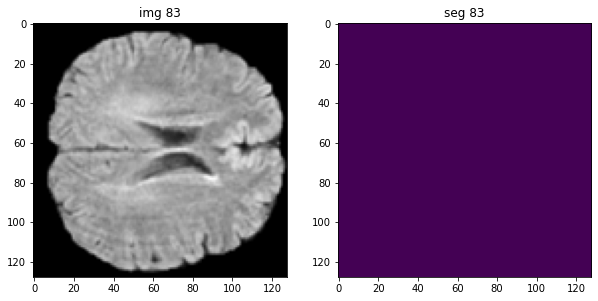

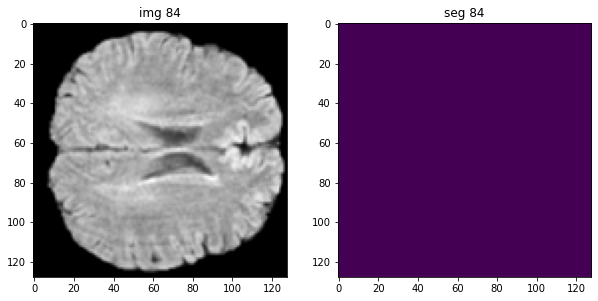

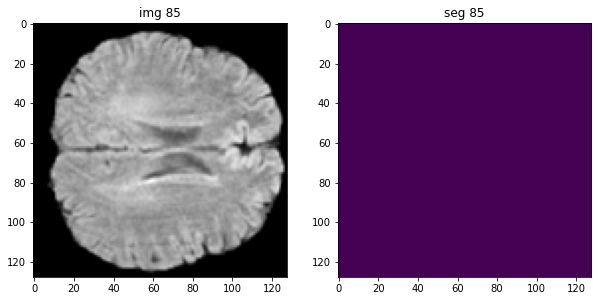

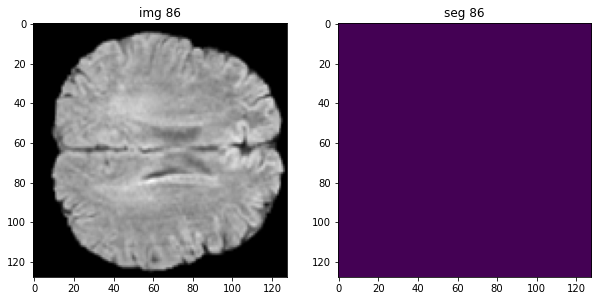

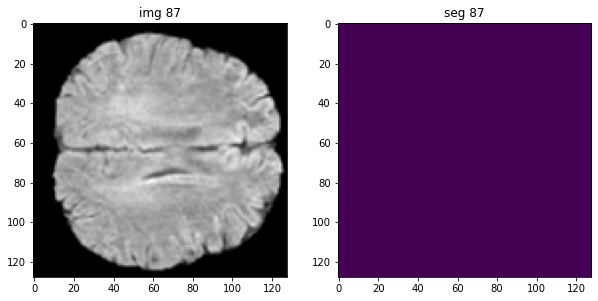

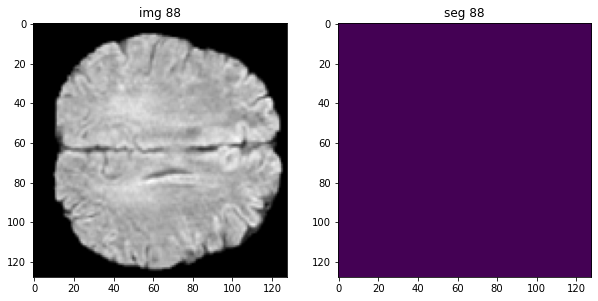

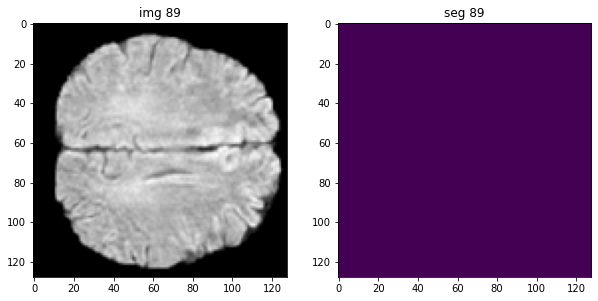

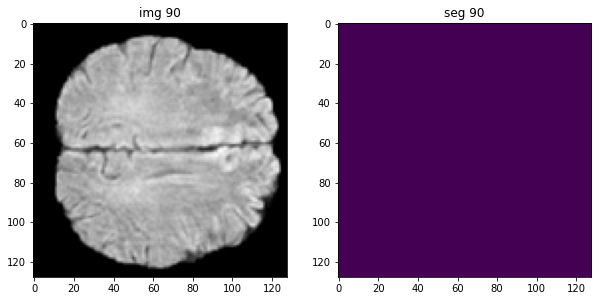

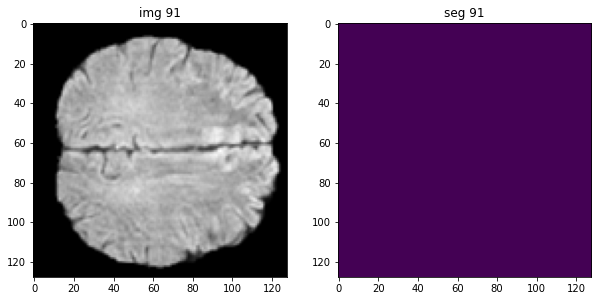

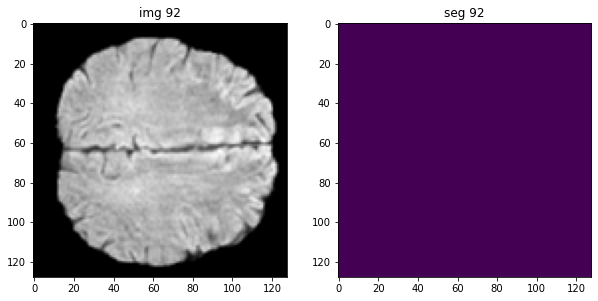

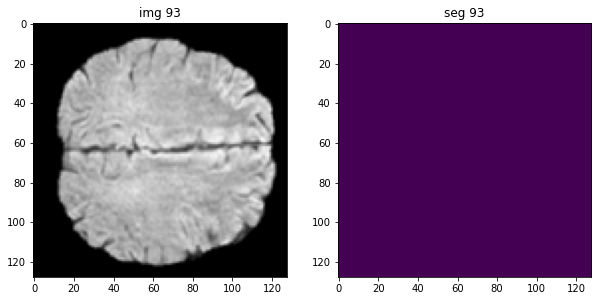

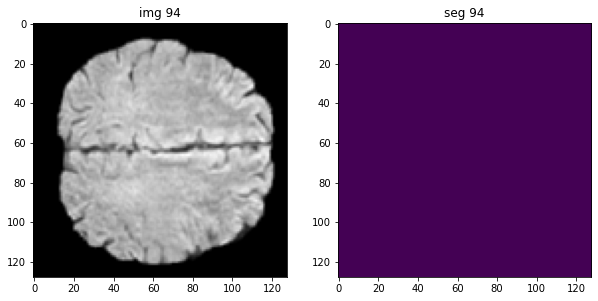

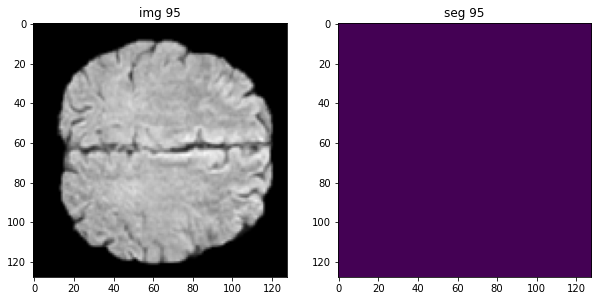

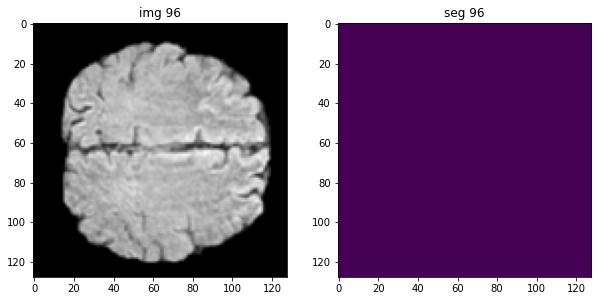

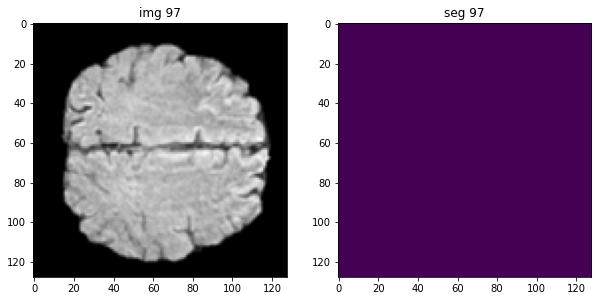

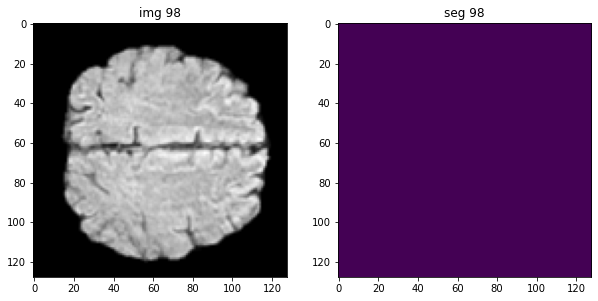

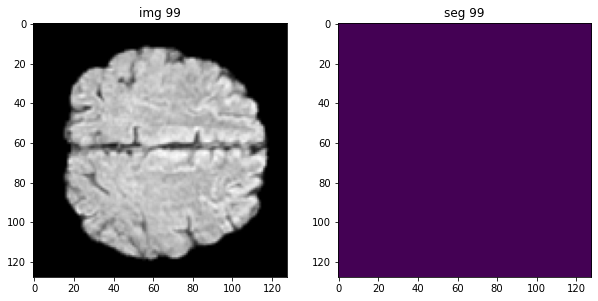

In [3]:
from monai.utils import first
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
firstdata = first(trainloader)
print(f"Image shape is: {firstdata['vol'].shape}")
print(f"Label shape is: {firstdata['seg'].shape}")

for i in tqdm_notebook(range(50, 100)):
    plt.figure("Training NIFTI", (10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"img {i}")
    plt.imshow(firstdata['vol'][0, 0, :, :, i], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title(f"seg {i}")
    plt.imshow(firstdata['seg'][0, 0, :, :, i])
    plt.show()